# Fitting Non-parametric Model with Parametric Model using SVI

## Theory

Unlike the previous notebook, we are trying to fit a parametric model to a non-parametric model. Moreover, we are not simply estimating the best-fit estimate of the parameters. We are performing inference on the known non-parametric model itself. By "non-parametric model", I mean some known distribution, which in my own work is the posterior distribution of some values $f$ given some data $d$, which need not be the values $f$ themselves. The "parametric model" is a model whose "outcomes" are the possible distributions of $f$, parameterized by some hyperparameters $\phi$. 

Let the non-parametric model be defined by the posterior $P(f|d)$ and the parametric model by $p_{\phi}(f)$, both calculable. Then, the objective is to minimize the KL-divergence between both distributions with respect to the hyperparameters $\phi$. There is an ambiguity in the order that we take. For instance, take
$$ \phi^{*} = \argmin_{\phi} KL[P(f|d) \ || \ p_{\phi}(f)]. $$
With this order, the KL-divergence becomes
$$
KL[P(f|d) \ || \ p_{\phi}(f)] = \mathbb{E}_{P(f|d)}[\log P(f|d) - \log p_{\phi}(f)]
$$
The primary issue with this choice is that typically $P(f|d)$ is much more expressive than $p_{\phi}(f)$. This means that if we estimate the above KL-divergence as a sample estimate, $f \sim P(f|d)$, it would give $p_{\phi}(f) \neq 0$ only for a set of measure zero in the space of functions that are integrated, due to the parametric model typically having a much lower-dimensional space than the non-parametric model.

The alternative ordering will not suffer from this issue. Let's continue. Consider
$$
KL[p_{\phi}(f) \ || \ P(f|d)] = \mathbb{E}_{p_{\phi}(f)}[\log p_{\phi}(f) - \log P(f|d)]
$$

By reversing the KL-divergence, we would sample $f \sim p_{\phi}(f)$, from which calculating $p_{\phi}(f)$ is by definition calculable on its own. 

As we will see in the example below, it is typical for a parametric model generates $f$ deterministically through some latent variable $z$. That is, there exists the functional relationship $f = f(z)$. If $f$ is one-to-one, then 

$$
p_{\phi}(f) \ df = p_{\phi}(z) \ dz
$$

Now, let’s try to calculate the reverse KL-divergence:

$$
\begin{aligned}
KL[p_{\phi}(f) \ || \ P(f|d)] & = \int df \ p_{\phi}(f) \ \log \left [ \frac{p_{\phi}(f)}{P(f|d)} \right ] \\
& \sim \int dz \ p_{\phi}(z) \ \log \left[ \frac{p_{\phi}(z)}{P(f(z)|d)} \right ] \\
& = KL[p_{\phi}(z) \ || \ P(f(z)|d)]
\end{aligned}
$$

**Note:** There are Jacobian terms and a modified normalization in the restricted PDF of $P$ in this expression. These terms are independent of $\phi$ and hence do not affect the fit.

The parametric model's PDF has support on a set of measure zero, so we should define a restriction of the non-parametric model defined on the support of the parametric model. It is much harder to define an extension (for the parametric model) than a restriction (for the non-parametric model).

$$
\begin{aligned}
KL[p_{\phi}(z) \ || \ P(f(z)|d)] & = \mathbb{E}_{p_{\phi}(z)}[\log p_{\phi}(z) - \log P(f(z) | d)] \\
& = -\mathbb{E}_{p_{\phi}(z)}[ \log P(f(z) | d) - \log p_{\phi}(z)] 
\end{aligned}
$$

This is a nice result. It implies that minimizing the original KL-divergence can be achieved by maximizing the log-likelihood analog $\mathbb{E}_{p_{\phi}(z)}[\log P(f(z) | d)]$, though there is the additional term to take into account.

## Conversion to SVI
The objective function above is a lot like the $ELBO$ in SVI (see Appendix A in [sparse-tinygp](https://github.com/edwarddramirez/sparse-tinygp/blob/main/01_inference_sparse_gp.ipynb)). In SVI, we attempt to approximate the posterior $p(z|y)$ with a guide $q_{\phi}(z)$ by maximizing the $ELBO$ with respect to the guide hyperparameters $\phi$:
$$ 
\begin{aligned}
ELBO & = \mathbb{E}_{q_{\phi}(z)}[ \log p(y | z) - KL[q_{\phi}(z) || p(z)] ] \\
& = \mathbb{E}_{q_{\phi}(z)}[ \log p(y | z) + \log p(z) - \log q_{\phi}(z) ]
\end{aligned}
$$ 
Therefore, we can use popular $ELBO$-optimization algorithms by posing the above problem in terms of SVI. We do this by first making the replacements $P(f|d) \rightarrow p(y|z)$ and $p_{\phi}(z) \rightarrow q_{\phi}(z)$ to our original objective. That is, 
$$
\begin{aligned}
-\mathbb{E}_{p_{\phi}(z)}[ \log P(f(z) | d) - \log p_{\phi}(z)] & \rightarrow -\mathbb{E}_{q_{\phi}(z)}[ \log p(z | y) - \log q_{\phi}(z)] \\
& = -\mathbb{E}_{q_{\phi}(z)}[ \log p(z | y) + 0 \times \log p(z) - \log q_{\phi}(z)].
\end{aligned}
$$ 
Thus, minimizing this expression is equivalent to maximizing the an ELBO receiving no contribution coming from the prior $p(z)$. Therefore, we can use an ELBO-optimizer, so long as we can remove contributions from the prior term. In our implementation, the prior isn't very important even if we don't remove it. 

## `numpyro` Implementation
### Example: Fitting a Gaussian Rate Model (Parametric Model) to a Gaussian Process posterior (Non-parametric Model)
#### Generate Gaussian Process Posterior by performing SVI on Poisson Data
This is the same dataset that we use in the [sparse-tinygp](https://github.com/edwarddramirez/sparse-tinygp/blob/main/01_inference_sparse_gp.ipynb) repo. We use the most basic GP model from that notebook to define our non-parametric model. 

##### Dataset
We generate Poisson samples from a rate function that has a Gaussian shape. This is the same dataset that is used in the [sparse-tinygp](https://github.com/edwarddramirez/sparse-tinygp) repo. Specifically, the true data is drawn from the following distribution:

$$
\begin{aligned}
y_i & \sim \mathrm{Pois}[\lambda(x_i)] \\
\lambda(x_i) & = N \exp \left [-\frac{(x_i - \mu)^2}{2 \sigma^{2}} \right ],
\end{aligned}
$$
where $\mu = 0$, $\sigma = \pi$, and $N = 10$.

For an implementation with a sparse GP, see [Appendix](#appendix-parametric-fit-to-sparse-gp).


In [1]:
import sys
sys.path.append("..")
from utils import custom
from utils.custom import log_like_poisson

import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import corner # for corner plots
from tqdm import tqdm # for progress bars

from tinygp import GaussianProcess, kernels # for Gaussian processes
import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
from jax import jit
from jax.random import poisson

import numpyro # for inference and probabilistic programming
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.handlers import scale

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


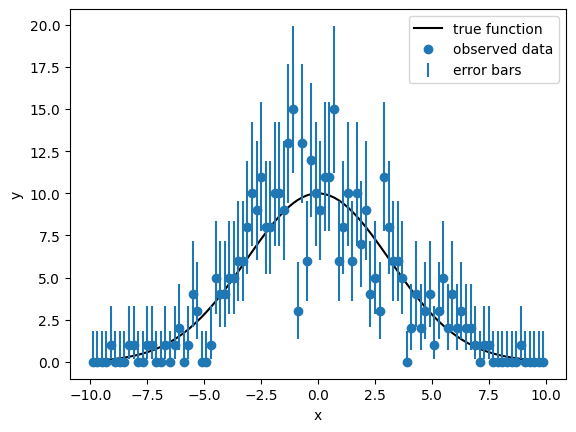

In [2]:
# parameters
p_tr = [0., np.pi, 10.]
mu_tr, sigma_tr, N_tr = p_tr

# generate data
x_bin = jnp.linspace(-10,10,101) # 10 random points between -1 and 1
x = 0.5 * (x_bin[:-1] + x_bin[1:])
log_rate = -(x-mu_tr)**2. / (2. * sigma_tr**2.)
y = N_tr * jnp.exp(log_rate)
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y)

# estimate error bars
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs.T]).T

# plot data with error bars
plt.plot(x, y, 'k', label='true function')
plt.plot(x, y_obs, 'o', label='observed data')
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', label='error bars')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

##### Obtain Approximate GP Posterior using SVI
We will take the nonparametric model $P(f | d)$ to be the approximate posterior $q_{\phi}$ obtained using SVI. We take a multivariate normal distribution as our guide via the `numpyro` [AutoMultivariateNormal](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoMultivariateNormal) autoguide. This guide is loaded within the `load_svi` function in `util.custom.py`.

A summary of the model and the SVI optimization scheme is given below
$$
\begin{aligned}
    y_i & \sim \mathrm {Pois}\{ \exp ( f( x_i ) ) \} \\
    f & \sim \mathcal{GP}(0, k_{\theta}) \\
    q_{\phi}(f) & = \mathcal{N}(\mathbf{m}, \mathbf{\Sigma})(f).
\end{aligned}
$$
The GP describes the log-rate to ensure that samples of the rate ($\lambda$) are positive. The dimension in the guide multivariate normal corresponds to a value of $f(x_i)$ for input $x_i$.

In [3]:
def m1(x, y=None):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    y : array
        y values (observations)
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define Gaussian Process prior on log_rate (zero mean and ExpSquared kernel)
    gp = GaussianProcess(kernel, x, diag = 1e-3)
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor('log_likelihood', log_like_poisson(rate, y))

In [4]:
# run SVI
svi_1, g1 = custom.load_svi(m1, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results_1 = svi_1.run(rng_key, 30000, x, y=y_obs)

100%|██████████| 30000/30000 [00:24<00:00, 1231.62it/s, init loss: 62861.3398, avg. loss [28501-30000]: 184.7116]


In [5]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
samples = g1.sample_posterior(key, svi_results_1.params, (1000,))
gp_samples = jnp.exp(samples['log_rate'])

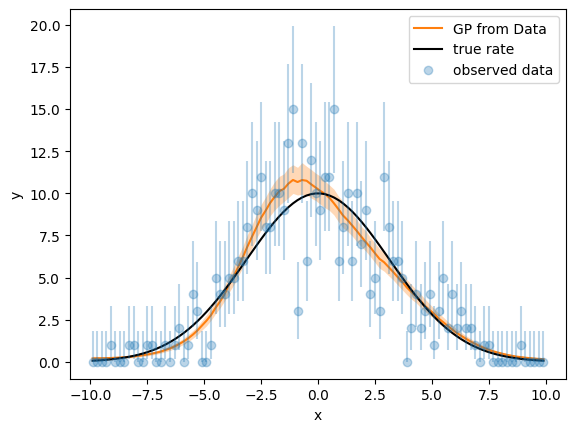

In [6]:
q1 = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q1[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q1[0],
    q1[2],
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, 'o', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

#### Fitting a Parametric Model to the Non-parametric GP Model
We fit the non-parametric model to a simpler model consisting of Gaussian rate functions using the formalism above. The model is summarized below:
$$ 
\begin{aligned}
    \mathrm{SVI \ Objective} & = \mathbb{E}_{q_{\phi}(f)}[\log Q_{\phi^{*}}(f) - \log q_{\phi}(f)] \\
    f(x_i) & = \log \left [ N \exp \left (-\frac{(x_i - \mu)^2}{2 \sigma^{2}} \right ) \right ] \\
    \mu & \sim U[-10,10] \\
    \sigma & \sim U[0.001, 20] \\
    N & \sim U[0.001, 100],
\end{aligned}
$$
where $\phi^{*}$ is the optimal set of GP hyperparameters corresponding to the non-parametric model. Here, $Q_{\phi^{*}}(f)$ is $P(f|d)$ from the formalism above and $q_{\phi}(f)$ corresponds to the SVI guide that we use for the parametric model when performing the fit to the non-parametric model. 

What is the role of the priors? As stated above, the priors on the latent variables $z = (\mu, \sigma, N)$ will not affect the value of the objective function. However, the `numpyro` autoguide will automatically use these priors to constrain the support of the guide to be consistent with the priors. This allows us to construct a reasonable guide function.

In [7]:
def m2(x, mu_q, cov_q):
    '''
    Parametric model to fit to non-parametric model

    Parameters
    ----------
    x : array
        x values (where observations are made)
    mu_q : array
        mean of the multivariate normal autoguide from previous fit
    cov_q : array
        covariance matrix of the multivariate normal autoguide from previous fit
    '''
    # sample parametric model latent variables from guide
    with scale(None, scale=1e-5): # rescale log prior term to remove prior influence on ELBO
        mu = numpyro.sample(
            "mu", dist.Uniform(-10, 10)
        )
        sigma = numpyro.sample(
            "sigma", dist.Uniform(0.0001, 20.)
        )
        N = numpyro.sample(
            "N", dist.Uniform(0.0001, 100.)
        )

    # compute rate and log rate as defined by parametric model
    rate = N * jnp.exp(-(x-mu)**2. / (2. * sigma**2.))
    log_rate = jnp.log(rate)

    # load guide from previous fit (nonparametric model) to compute log likelihood term
    mvn = dist.MultivariateNormal(loc = mu_q, covariance_matrix = cov_q)
    numpyro.factor("log_likelihood", mvn.log_prob(log_rate)) 

In [8]:
# Load the guide parameters and mean / covariance matrix of the guide
params_1 = svi_results_1.params
m = params_1['auto_loc']
L = params_1['auto_scale_tril'] 
S = L @ L.T

In [9]:
# run SVI
svi_2, g2 = custom.load_svi(m2, lr = 0.01, num_particles = 16)
rng_key, key = jax.random.split(rng_key)
svi_results_2 = svi_2.run(key, 10000, x, mu_q = m, cov_q = S)

100%|██████████| 10000/10000 [00:06<00:00, 1522.76it/s, init loss: 909.5414, avg. loss [9501-10000]: -217.5891]


In [10]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
temp_samples = g2.sample_posterior(key, svi_results_2.params, (1000,))
gauss_samples = temp_samples['N'][:,None] * np.exp(-(x[None,:]-temp_samples['mu'][:,None])**2. / (2. * temp_samples['sigma'][:,None]**2.))

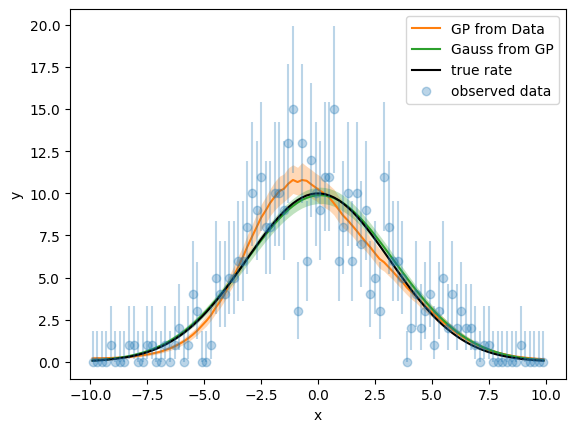

In [11]:
q2 = np.quantile(gauss_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q1[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q1[0],
    q1[2],
    alpha=0.3,
    lw=0,
    color="C1",
)
plt.plot(x, q2[1], color = 'C2', label = 'Gauss from GP')
plt.fill_between(
    x,
    q2[0],
    q2[2],
    alpha=0.3,
    lw=0,
    color="C2",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, 'o', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

##### Comments
This parametric model is not expressive enough to match the non-parametric model. Interestingly, it locks on to the true distribution from this lack of expressiveness. Let's try making it more expressive and see how things change. We make the following change:
$$
\begin{aligned}
    f(x) & = \log N - \frac{(x - \mu)^2}{2\sigma^2} \\
    & \rightarrow \sum_{i=0}^{5} \ a_i x^i
\end{aligned}
$$

In [12]:
def m3(x, mu_q, cov_q):
    '''
    Parametric model to fit to non-parametric model

    Parameters
    ----------
    x : array
        x values (where observations are made)
    mu_q : array
        mean of the multivariate normal autoguide from previous fit
    cov_q : array
        covariance matrix of the multivariate normal autoguide from previous fit
    '''
    # sample parametric model latent variables from guide
    with scale(None, scale=1e-5): # rescale log prior term to remove prior influence on ELBO
        a0 = numpyro.sample('a0', dist.Uniform(-5., 10.))
        a1 = numpyro.sample('a1', dist.Uniform(-5., 10.))
        a2 = numpyro.sample('a2', dist.Uniform(-5., 10.))
        a3 = numpyro.sample('a3', dist.Uniform(-5., 10.))
        a4 = numpyro.sample('a4', dist.Uniform(-5., 10.))
        a5 = numpyro.sample('a5', dist.Uniform(-5., 10.))

    # compute rate and log rate as defined by parametric model
    log_rate = a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4 + a5 * x**5 

    # load guide from previous fit (nonparametric model) to compute log likelihood term
    mvn = dist.MultivariateNormal(loc = mu_q, covariance_matrix = cov_q)
    numpyro.factor("log_likelihood", mvn.log_prob(log_rate)) 

In [13]:
# run SVI
svi_3, g3 = custom.load_svi(m3, lr = 0.0005, num_particles = 16) # lower lr for better convergence
rng_key, key = jax.random.split(rng_key)
svi_results_3 = svi_3.run(key, 100000, x, mu_q = m, cov_q = S)

100%|██████████| 100000/100000 [00:57<00:00, 1746.78it/s, init loss: 938591191040.0000, avg. loss [95001-100000]: 12.4483]     


In [14]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
flex_samples = g3.sample_posterior(key, svi_results_3.params, (1000,))
flex_log_rate = (flex_samples['a0'][:,None] + flex_samples['a1'][:,None] * x[None,:] + flex_samples['a2'][:,None] * x[None,:]**2 + 
                 flex_samples['a3'][:,None] * x[None,:]**3 + flex_samples['a4'][:,None] * x[None,:]**4 + flex_samples['a5'][:,None] * x[None,:]**5
                  )
flex_rate = jnp.exp(flex_log_rate)

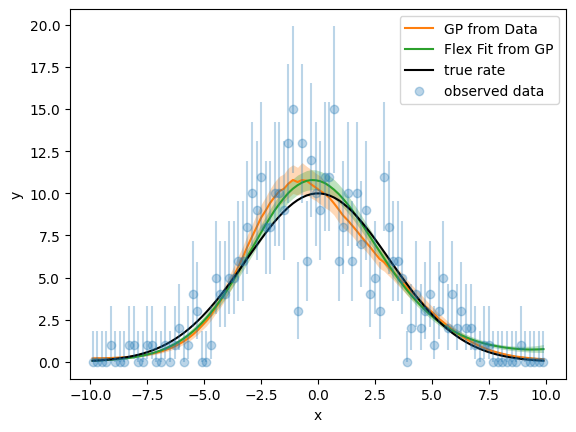

In [15]:
q3 = np.quantile(flex_rate, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q1[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q1[0],
    q1[2],
    alpha=0.3,
    lw=0,
    color="C1",
)
plt.plot(x, q3[1], color = 'C2', label = 'Flex Fit from GP')
plt.fill_between(
    x,
    q3[0],
    q3[2],
    alpha=0.3,
    lw=0,
    color="C2",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, 'o', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

As we see, it matches the GP model more closely!

# Appendix: Parametric Fit to Sparse GP

This is optional material since it doesn't generalize to other non-parametric models. It shows how to implement the above formalism to a sparse GP non-parametric model. For more details on sparse GPs and explanation of the code below, see [sparse-tinygp](https://github.com/edwarddramirez/sparse-tinygp) for more details. Sticking to the Poisson data above, a sparse GP implementation is summarized as follows. We adopt vectorized notation. That is, for example, $\mathbf{f} = f(\mathbf{x})$ for observation inputs $\mathbf{x} = \sum_i x_i \mathbf{\hat{e}}_i$ and $\mathbf{u} = f(\mathbf{x_{u}})$ for inducing point inputs $\mathbf{x}_{u} = \sum_j x_{u,j} \mathbf{\hat{e}}_j$.   

$$
\begin{aligned}
    \mathbf{y} & \sim \mathrm {Pois}\{ \exp ( \mathbf{f} ) \} \\
    \mathbf{f} & \sim \mathcal{GP}(0, k_{\theta})(\mathbf{f} \ | \ \mathbf{u}) \\
    \mathbf{u} & \sim \mathcal{GP}(0, k_{\theta})(\mathbf{u}) \\
    q_{\phi}(\mathbf{u}) & = \mathcal{N}(\mathbf{m}, \mathbf{\Sigma})(\mathbf{u}) \\
    q_{\phi}(\mathbf{f}) & \equiv \int du \ p(\mathbf{f}|\mathbf{u}) q(\mathbf{u}),
\end{aligned}
$$

For our implementation, the “GP-posterior” is approximated by an MVN. For the vanilla GP, the log-likelihood is given. For the SVGP, one must convert the guide function defined in the space of inducing points to the space of actual function values. This can be done analytically, but takes some work. 

Recall, we define the approximate posterior for $f$ as 
$$
q(f) \equiv \int du \ p(f|u) q(u),
$$

where $q(u)$ is the guide obtained from the SVI fit and $p(f|u)$ is the prior GP (with optimal hyperparameters $\theta^{*}$) conditioned on the inducing points $u$. Therefore, we have to compute an integral of two MVN distributions, where the input variable of one $u$ appears in the mean and covariance matrix of the other $f|u$. This integral is computed analytically in [Hensman15](https://proceedings.mlr.press/v38/hensman15.pdf). First, define the joint GP of $f,u$ as (Eq. 2)

$$
p(\mathbf{f}, \mathbf{u})=\mathcal{N}\left(\left.\left[\begin{array}{c}\mathbf{f} \\\mathbf{u}\end{array}\right] \right\rvert\, \mathbf{0},\left[\begin{array}{ll}\mathbf{K}_{n n} & \mathbf{K}_{n m} \\\mathbf{K}_{n m}^{\top} & \mathbf{K}_{m m}\end{array}\right]\right)
$$

Then, with 

$$
q(\mathbf{u}) = \mathcal{N}(\mathbf{u} | \mathbf{m} , \mathbf{S}) ,
$$

$$
q(\mathbf{f})=\mathcal{N}\left(\mathbf{f} \mid \mathbf{A m}, \mathbf{K}_{n n}+\mathbf{A}\left(\mathbf{S}-\mathbf{K}_{m m}\right) \mathbf{A}^{\top}\right),
$$

where $\mathbf{A} = \mathbf{K}_{nm} \mathbf{K}^{-1}_{mm}$. This is what we take as the non-parametric model, $Q_{\phi^{*}}(f)$, for a sparse GP fit.

That's it. Now we just need to modify to account for these changes.

#### Fit Sparse GP to Poisson Data

In [16]:
def m1(x, xu, y=None, gp_rng_key = jax.random.PRNGKey(0)):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    xu : array
        x values of inducing points
    y : array
        y values (observations)
    gp_rng_key : PRNGKey
        random key for sampling from GP
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define GP on inducing points
    gp_u = GaussianProcess(kernel, xu, diag = 1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())
    
    # sample GP at x from inducing point samples
    _, gp_x = gp_u.condition(log_rate_u, x, diag=1e-3)
    log_rate = gp_x.sample(key = gp_rng_key)
    rate = jnp.exp(log_rate)

    # load function values and compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y)) 

In [17]:
# define inducing points
xu = jnp.linspace(-10,10,20)

# run SVI
svi_1, g1 = custom.load_svi(m1, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results_1 = custom.svi_loop(rng_key, 10000, svi_1, x, xu, y_obs)

100%|██████████| 10000/10000 [00:11<00:00, 872.13it/s]


In [18]:
# sample the GP at x using custom (vectorized) sampler
rng_key, key = jax.random.split(rng_key)
pred = Predictive(g1, num_samples = 1, params = svi_results_1.params)
gp_samples = jnp.exp(custom.get_gp_samples_at_x_from_u(rng_key, 1000, pred, svi_results_1.params, x, xu))

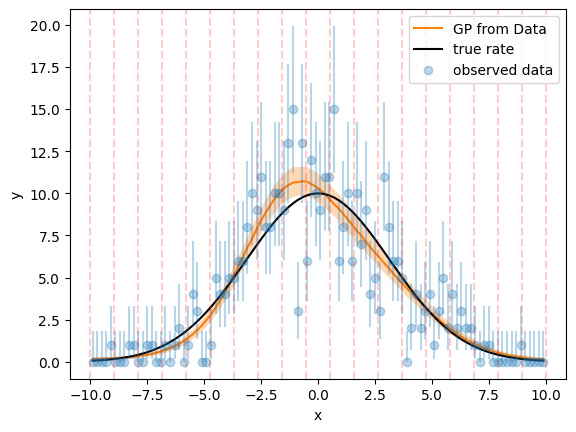

In [19]:
q1 = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q1[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q1[0],
    q1[2],
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, 'o', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

# plot inducing point locations
for xu_v in xu:
    if xu_v == xu[0]:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2, label = 'inducing points')
    else:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2)

#### Fit Gaussian Parametric Model to Sparse GP Posterior
Same parametric model as `m2` above.

In [20]:
def m2(x, mu_q, cov_q):
    '''
    Parametric model to fit to non-parametric model

    Parameters
    ----------
    x : array
        x values (where observations are made)
    mu_q : array
        mean of the multivariate normal autoguide from previous fit
    cov_q : array
        covariance matrix of the multivariate normal autoguide from previous fit
    '''
    # sample parametric model latent variables from guide
    with scale(None, scale=1e-5): # rescale log prior term to remove prior influence on ELBO
        mu = numpyro.sample(
            "mu", dist.Uniform(-10, 10)
        )
        sigma = numpyro.sample(
            "sigma", dist.Uniform(0.0001, 20.)
        )
        N = numpyro.sample(
            "N", dist.Uniform(0.0001, 100.)
        )

    # compute rate and log rate as defined by parametric model
    rate = N * jnp.exp(-(x-mu)**2. / (2. * sigma**2.))
    log_rate = jnp.log(rate)

    # load guide from previous fit (nonparametric model) to compute log likelihood term
    mvn = dist.MultivariateNormal(loc = mu_q, covariance_matrix = cov_q)
    numpyro.factor("log_likelihood", mvn.log_prob(log_rate)) 

In [21]:
# need double precision for the mvn object in model to avoid nan-log-likelihoods
jax.config.update("jax_enable_x64", True) 
x = jnp.float64(x)

# Load the guide parameters and mean and covariance of the inducing point GP
params_1 = svi_results_1.params
m = params_1['auto_loc']
L = params_1['auto_scale_tril'] 
S = L @ L.T

# Define GP with kernel using the optimized hyperparameters on observation inputs x and inducing point inputs xu
kernel = custom.load_kernel(before_fit = False, params = params_1)
x_aug = jnp.concatenate([x, xu])
gp = GaussianProcess(kernel, x_aug)

# compute blocks of the covariance matrix for p(f,u)
Nx = x.shape[0]
Kaa = gp.covariance
Kxx = Kaa[:Nx, :Nx]
Kuu = Kaa[Nx:, Nx:]
Kxu = Kaa[:Nx, Nx:]

# define the A matrix
A = Kxu @ jnp.linalg.inv(Kuu)

# define the mean
mu_q = A @ m

# define the covariance
cov_q = Kxx + A @ (S - Kuu) @ A.T

In [22]:
# run SVI
svi_2, g2 = custom.load_svi(m2, lr = 0.01, num_particles = 16)
rng_key, key = jax.random.split(rng_key)
svi_results_2 = svi_2.run(key, 10000, x, mu_q = mu_q, cov_q = cov_q)

100%|██████████| 10000/10000 [00:06<00:00, 1457.47it/s, init loss: 478.3303, avg. loss [9501-10000]: -691.3724]


In [23]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
temp_samples = g2.sample_posterior(key, svi_results_2.params, (1000,))
gauss_samples = temp_samples['N'][:,None] * np.exp(-(x[None,:]-temp_samples['mu'][:,None])**2. / (2. * temp_samples['sigma'][:,None]**2.))

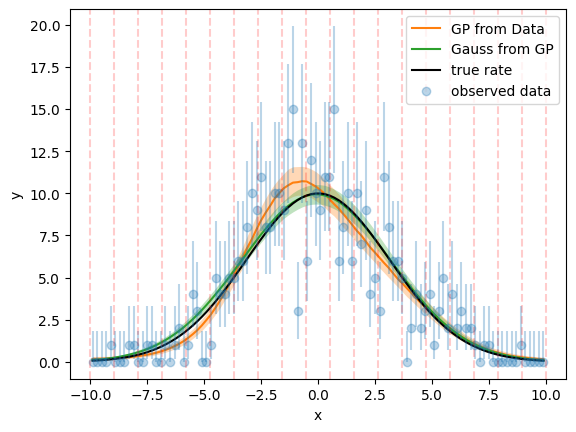

In [24]:
q2 = np.quantile(gauss_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q1[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q1[0],
    q1[2],
    alpha=0.3,
    lw=0,
    color="C1",
)
plt.plot(x, q2[1], color = 'C2', label = 'Gauss from GP')
plt.fill_between(
    x,
    q2[0],
    q2[2],
    alpha=0.3,
    lw=0,
    color="C2",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, 'o', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

# plot inducing point locations
for xu_v in xu:
    if xu_v == xu[0]:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2, label = 'inducing points')
    else:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2)